In [1]:
%reload_ext autoreload
%autoreload 2

## This notebook makes a 1D track graph to project all 4-arm task data onto. 
Only run once to make the graph. Once it is in the database, future linearization refers to the name of the graph in "linearization".

### 1. Load an example: retrieve a 2D position from the `IntervalPositionInfo` table

First we specify the nwb file and get the name of the copied version (without the ephys data) that is used as a key.

In [53]:
import spyglass as nd
import matplotlib.pyplot as plt
import spyglass as nd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from spyglass.common.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common import IntervalList
from spyglass.common.common_position import IntervalPositionInfo
from spyglass.common.common_position import IntervalPositionInfoSelection
from spyglass.common.common_position import IntervalLinearizationSelection
from spyglass.common.common_position import IntervalLinearizedPosition
from spyglass.common.common_position import TrackGraph

nwb_file_name = 'molly20220416.nwb'
nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)
nwb_copy_file_name

'molly20220416_.nwb'

Now specify an example position interval we want to look at.

In [4]:

# I include this cell here in case ```IntervalPositionInfo``` was not made before.
IntervalPositionInfoSelection.insert1(
        {'nwb_file_name': nwb_copy_file_name,
         'interval_list_name': 'pos 1 valid times',
         'position_info_param_name': 'default' #default parameters are in the database already
        }, skip_duplicates=True)

In [5]:
IntervalPositionInfo.populate({'nwb_file_name': nwb_copy_file_name})

In [6]:
IntervalPositionInfo & {'nwb_file_name': nwb_copy_file_name}

position_info_param_name name for this set of parameters,nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,analysis_file_name name of the file,head_position_object_id,head_orientation_object_id,head_velocity_object_id
default,molly20220416_.nwb,pos 0 valid times,molly20220416_JA5CWSD5PQ.nwb,b6ecc808-7baf-4573-9fc7-976d47ed5638,e6ad2feb-d65d-4162-a43d-dff90269b714,38ac66ee-9d9d-49cd-8bac-6490d4a49a2c
default,molly20220416_.nwb,pos 1 valid times,molly20220416_GNEW7KP6HA.nwb,659de521-da58-4390-a68a-e92b067ba749,284204f2-861a-446b-ae6b-8d6d9a05c66c,1a399a4b-510e-4649-8b77-e083ac9a40b3
default,molly20220416_.nwb,pos 10 valid times,molly20220416_ISMWS3MD7G.nwb,d6d0a962-0631-45f1-a058-970d9cdedc09,7c5a2add-e4cb-400e-8a44-e58d8db529f9,3b918658-1a4a-401a-84fc-7066cc1eb35d
default,molly20220416_.nwb,pos 2 valid times,molly20220416_21D8ZWUGE4.nwb,bf1f6448-6543-4eb6-9afa-ea9f0543ca9f,c4a1a877-8808-413b-864f-05fc22d064d2,b41f3c63-38b7-473a-9f2e-dd61f72c8167
default,molly20220416_.nwb,pos 3 valid times,molly20220416_PTC4MFSYPO.nwb,22d4387c-1859-4732-ba2d-904390a67e6a,e2d743d3-2655-4c4f-974a-022b4c967fd8,05200b61-4020-4514-8f07-29146099cea9
default,molly20220416_.nwb,pos 4 valid times,molly20220416_MNS332KCLC.nwb,2a7c0419-fc25-4b01-b4c7-582b89100fe0,b225a136-a514-4692-8b17-7d3b9f7352a7,2ecc5b16-c12d-4a10-8e2c-adf1658b9b42
default,molly20220416_.nwb,pos 5 valid times,molly20220416_WOGWOSZ1VI.nwb,00da29d2-f7e6-49f3-8f8d-b74356e70231,cd94752e-373b-4bb3-aca5-fccb84ce75f4,a0d41679-a5a0-4817-a8d7-9771bfdb8865
default,molly20220416_.nwb,pos 6 valid times,molly20220416_0DX1LBJJYO.nwb,92c14c1a-cea9-4ab2-bbfc-0f848007e57d,65294f67-1151-4098-b812-58e3a648ce4c,fda55db3-f439-4af7-9071-b76e71169403
default,molly20220416_.nwb,pos 7 valid times,molly20220416_XX8JWNFYJW.nwb,84a4ed19-305a-4431-8aad-26834f64a291,1db65289-4b19-4d70-9767-2b0fb8261c29,2292bbc5-5aba-4855-9735-c2e68f9e1942
default,molly20220416_.nwb,pos 8 valid times,molly20220416_U61SZGC0R6.nwb,6a8edc63-0036-491e-995b-a4a9917e8f1b,70de1151-99c0-40f1-a1a3-078c06ca3396,26a4fe80-1d71-47cc-8d54-0b6d380bdd93


In [45]:
position_info = (IntervalPositionInfo() &
                 {'nwb_file_name': nwb_copy_file_name,
                  'interval_list_name': 'pos 1 valid times',
                  'position_info_param_name': 'default'}
                ).fetch1_dataframe()
position_info

,head_position_x,head_position_y,head_orientation,head_velocity_x,head_velocity_y,head_speed
time,,,,,,
1.650141e+09,207.87500,232.6250,1.700499,3.854548,0.850317,3.947224
1.650141e+09,208.06250,232.6875,1.725115,4.721094,0.937317,4.813242
1.650141e+09,208.50000,232.7500,1.750650,5.000946,0.823503,5.068295
1.650141e+09,209.00000,232.8750,1.700499,4.585640,0.520828,4.615123
1.650141e+09,209.18750,233.0000,1.590794,3.642898,0.147941,3.645901
...,...,...,...,...,...,...
1.650143e+09,209.78125,211.7500,-0.800941,-0.632421,8.309143,8.333176
1.650143e+09,209.84375,212.2500,-0.831519,-0.447843,7.802820,7.815662
1.650143e+09,209.75000,212.5625,-0.855988,-0.290587,6.997545,7.003576


In [46]:
from spyglass.common.common_behav import RawPosition

raw_position_df = (RawPosition() &
                   {'nwb_file_name': nwb_copy_file_name,
                    'interval_list_name': 'pos 1 valid times'}).fetch1_dataframe()

Let's linearize the head position. We will plot the head position to get a sense of the data.
As shown in the next plot, head position(in cm) is obtained by a conversion from pixel.
In subsequent linearization, we work with cm. 

Text(0.5, 1.0, 'Head Position')

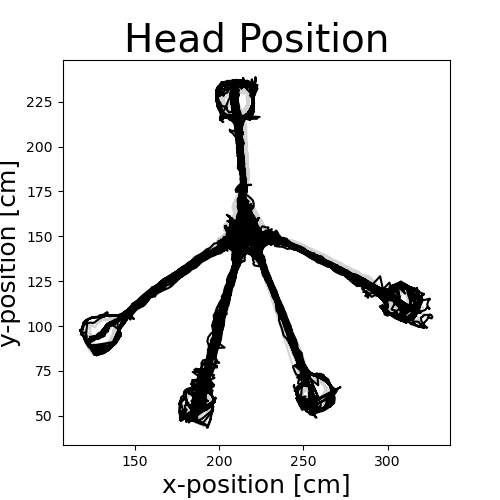

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(position_info.head_position_x, position_info.head_position_y, color='lightgrey')
ax.plot(raw_position_df.xloc*0.25, raw_position_df.yloc*0.25, color='black') #0.25 converts pixel to cm
ax.set_xlabel('x-position [cm]', fontsize=18)
ax.set_ylabel('y-position [cm]', fontsize=18)
ax.set_title('Head Position', fontsize=28)

In [10]:
from spyglass.common.common_position import LinearizationParameters

LinearizationParameters.insert1({'linearization_param_name': 'default'}, skip_duplicates=True)
LinearizationParameters()

linearization_param_name name for this set of parameters,use_hmm use HMM to determine linearization,route_euclidean_distance_scaling How much to prefer route distances between successive time points that are closer to the euclidean distance. Smaller numbers mean the route distance is more likely to be close to the euclidean distance.,sensor_std_dev Uncertainty of position sensor (in cm).,diagonal_bias Biases the transition matrix to prefer the current track segment.
deafult,0,1.0,5.0,0.5
default,0,1.0,5.0,0.5


### 2. Specifying the track graph for linearization

In order to linearize the data, we must build a graph of nodes and edges that specify the geometry of the track in 1D and 2D. This will be referred to as the `TrackGraph`.

We do this by specifying four variables:
1. `node_positions` are the 2D positions of the graph (in cm)
2. `edges` specify how the nodes are connected. Each edge consists of a pair of nodes. Each node is labeled by their respective index in `node_positions`. For example, (79.910, 216.720) is the 2D position of node 0 and (183.784, 45.375) is the 2D position of node 8. So specifying (0, 8) means there is an edge between node 0 and node 8
3. `linear_edge_order` specifies how the edges are laid out in linear space in *order*. As before, each edge consists of a pair of nodes, which are labeled by their index. The order of the nodes controls their order in 1D space. So edge (0, 1) connects node 0 and node 1 and node 0 will be placed in linear position space before node 1. Specifying edge (1, 0) would reverse the linear positions for that edge.
4. `linear_edge_spacing` specifies the spacing between each edge. This can either by a single number or be an array the length of the number of gaps between edges. If it is a single number, all edges will have a gap between them (15 cm in this example). If it is an array, then the spacing between edges can be individually controlled. You may want to have gaps between edges if they are not spatially connected in 2D space.

For more examples, see this notebook: https://github.com/LorenFrankLab/track_linearization/blob/master/notebooks/

##### 2.1 Interactively selecting the track graph nodes and edges: NodePicker

The linearization heavily depends on how you specify the track graph. Setting the node positions and edges can be diffcult. To help simplify this process, we can use the `NodePicker` to interactively set the node positions and edges based on the video of the track.

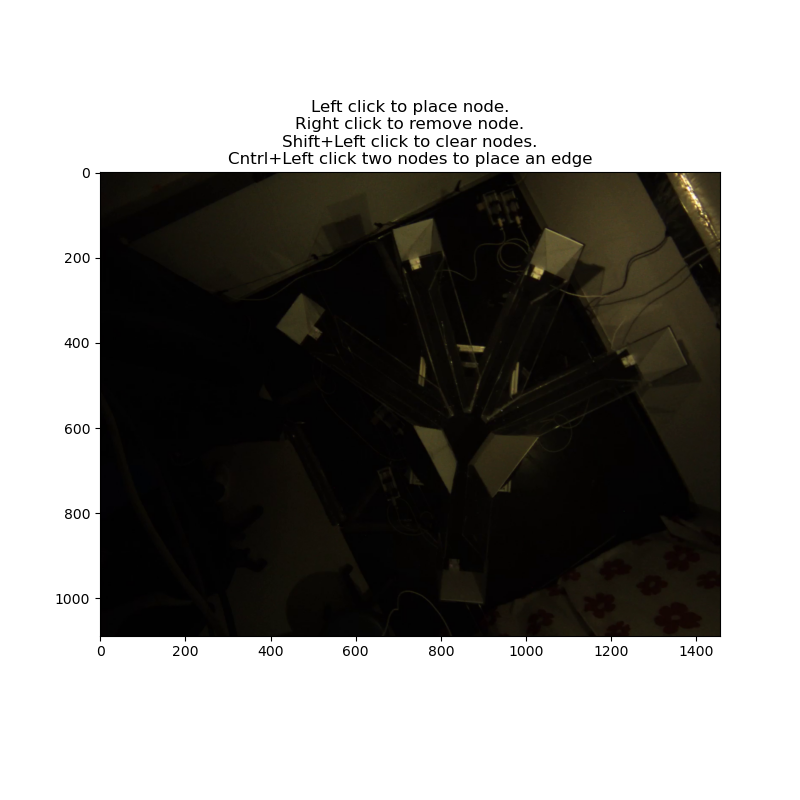

In [44]:
%matplotlib widget

from spyglass.common.common_position import NodePicker
import pynwb


key = {
    'nwb_file_name': nwb_copy_file_name,
    'interval_list_name': 'pos 1 valid times'
}

epoch = int(key['interval_list_name']
            .replace('pos ', '')
            .replace(' valid times', '')
            ) + 1
video_info = (nd.common.common_behav.VideoFile() &
              {'nwb_file_name': key['nwb_file_name'],
               'epoch': epoch}).fetch1()

io = pynwb.NWBHDF5IO('/opt/stelmo/nwb/raw/' +
                     video_info['nwb_file_name'], 'r')
nwb_file = io.read()
nwb_video = nwb_file.objects[video_info['video_file_object_id']]
video_filename = nwb_video.external_file.value[0]

fig, ax = plt.subplots(figsize=(8, 8))
picker = NodePicker(ax=ax, video_filename=video_filename)

In [11]:
node_positions = np.array([
    (841,936),  # home well
    (857,706),  # center platform start
    (791,586),  # well 1 start
    (507,385),  # well 1 end
    (841,553),  # well 2 start
    (744,218),  # well 2 end
    (895,558),  # well 3 start
    (1031,239), # well 3 end
    (935,592),  # well 4 start
    (1242,443), # well 4 end
    (863,571)   # midline top
])*0.25 #note the conversion to cm

edges = np.array([
    (0, 1),
    (1,10),
    (1,2), # center 
    (2,3), # arm1
    (1,4), # center 
    (4,5), # arm2
    (1,6), # center 
    (6,7), # arm3
    (1,8), # center 
    (8,9),  # arm4  
])

linear_edge_order = edges
linear_edge_spacing = [0,40,0,40,0,40,0,40,0]

##### 2.2 make graph and take a look

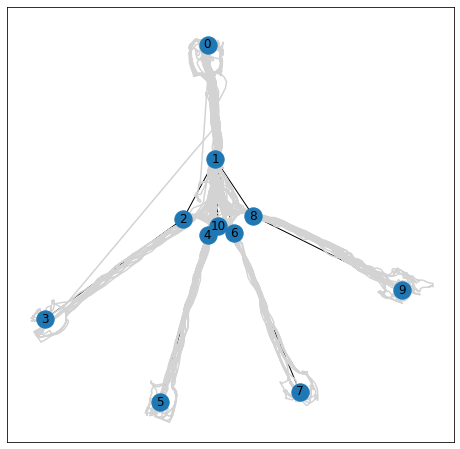

In [12]:
import track_linearization as ti


track_graph=ti.make_track_graph(node_positions, edges)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(position_info.head_position_x, position_info.head_position_y, color='lightgrey')

ti.plot_track_graph(track_graph)

#### 2.3 do lumping for the center platform

In [13]:
track_graph.edges

EdgeView([(0, 1), (1, 10), (1, 2), (1, 4), (1, 6), (1, 8), (2, 3), (4, 5), (6, 7), (8, 9)])

In [14]:
# Use ```edge_specialty``` to set lumping for center platform
edge_specialty=np.zeros(len(edges))

#edge (1,10) is the one to be lumped to
edge_specialty[1]=1 

#edge (1,2), (1,4),(1,6),(1,8) is the one to be lumped from
edge_specialty[np.array([2,3,4,5])]=5 

edge_specialty

array([0., 1., 5., 5., 5., 5., 0., 0., 0., 0.])

In [48]:
position=np.array([position_info.head_position_x, position_info.head_position_y]).T
linear_position_df=ti.get_linearized_position(position,track_graph,edge_order=linear_edge_order,edge_specialty=edge_specialty,edge_spacing=linear_edge_spacing)

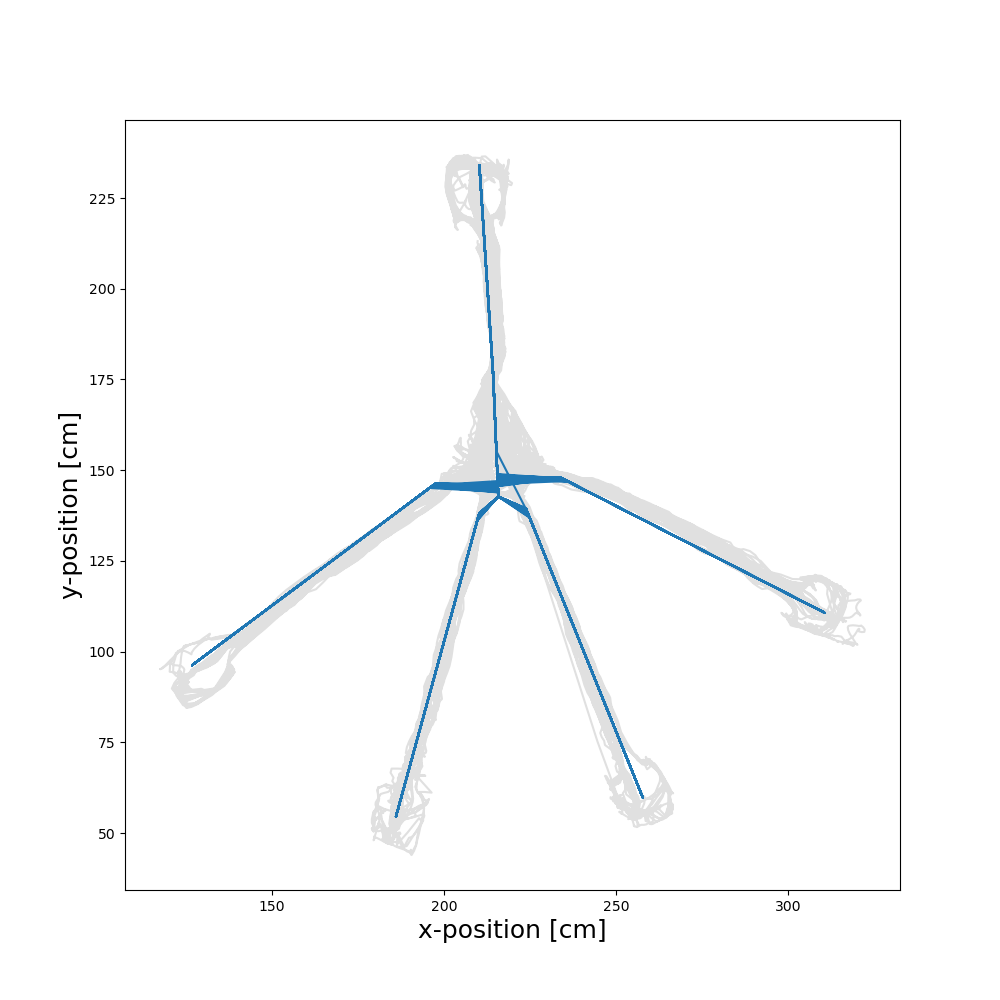

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(position_info.head_position_x, position_info.head_position_y,
        color='lightgrey', alpha=0.7, zorder=0)
ax.set_xlabel('x-position [cm]', fontsize=18)
ax.set_ylabel('y-position [cm]', fontsize=18)
ax.plot(linear_position_df.projected_x_position, linear_position_df.projected_y_position)

#### 2.4 insert into database for final inspection.
Do step 2.1 to 2.4 multiple times until you are happy with the result.

Note: the database TrackGraph object has more methods to visualize. 
      Hence we do more visualization in step 2.4

In [17]:
#TrackGraph.alter()

In [21]:
(TrackGraph() & {'track_graph_name': '4 arm lumped'}).delete()

Deleting 4 rows from `common_position`.`__interval_linearized_position`
Deleting 4 rows from `common_position`.`#interval_linearization_selection`
Deleting 1 rows from `common_position`.`track_graph`


Commit deletes? [yes, No]:  yes


Deletes committed.


1

In [22]:
from spyglass.common.common_position import TrackGraph

TrackGraph.insert1(
    {'track_graph_name': '4 arm lumped',
     'environment': '4 arm lumped',
     'node_positions': node_positions,
     'edges': edges,
     'linear_edge_order': linear_edge_order,
     'linear_edge_spacing': linear_edge_spacing,
     'linear_edge_specialty':edge_specialty,
     },  replace=True)


graph = TrackGraph() & {'track_graph_name': '4 arm lumped'}
graph

track_graph_name,environment Type of Environment,"node_positions 2D position of track_graph nodes, shape (n_nodes, 2)","edges shape (n_edges, 2)","linear_edge_order order of track graph edges in the linear space, shape (n_edges, 2)","linear_edge_spacing amount of space between edges in the linear space, shape (n_edges,)","linear_edge_specialty denote what edges (denote by 5) are going to be lumped to what edge (denote by 1), shape (n_edges,)"
4 arm lumped,4 arm lumped,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=


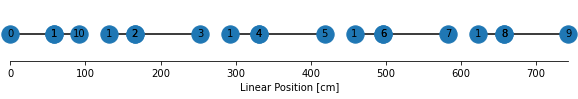

In [23]:
fig, ax = plt.subplots(figsize=(10, 1))
graph.plot_track_graph_as_1D(
    ax=ax)

Text(0.5, 1.0, 'Linear Position')

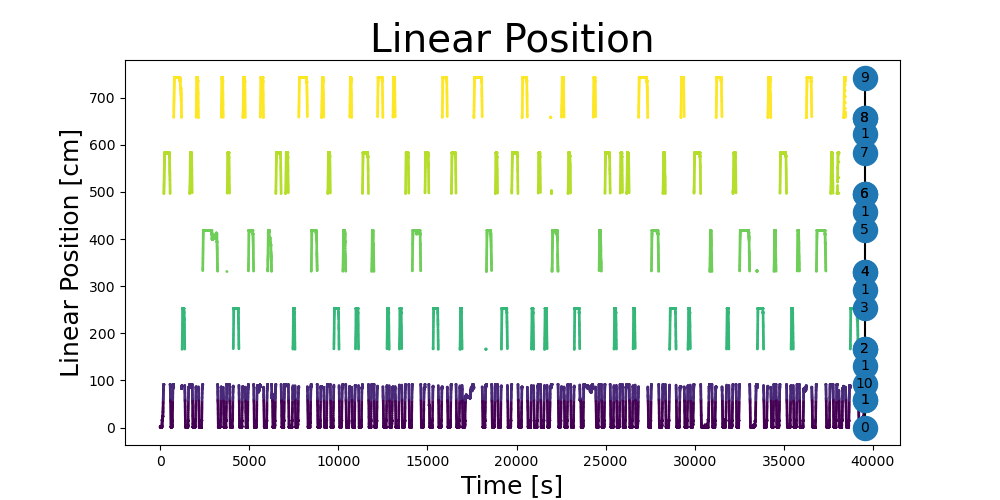

In [51]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(linear_position_df.index,
            linear_position_df.linear_position,
            c=linear_position_df.track_segment_id,
            s=1)
graph.plot_track_graph_as_1D(
    ax=ax,
    axis='y',
    other_axis_start=linear_position_df.index[-1] + 10)

ax.set_xlabel('Time [s]', fontsize=18)
ax.set_ylabel('Linear Position [cm]', fontsize=18)
ax.set_title('Linear Position', fontsize=28)

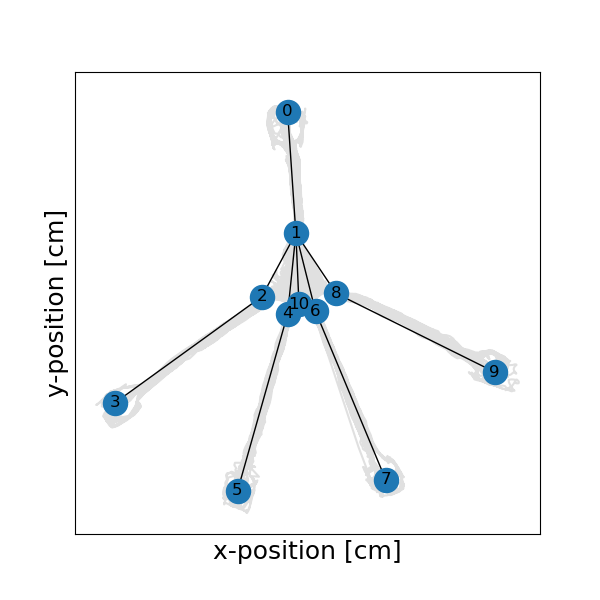

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(position_info.head_position_x, position_info.head_position_y,
        color='lightgrey', alpha=0.7, zorder=0)
ax.set_xlabel('x-position [cm]', fontsize=18)
ax.set_ylabel('y-position [cm]', fontsize=18)
graph.plot_track_graph(ax=ax)

### Done! In the future, use ```{'track_graph_name':4 arm lumped}``` in the table ```IntervalLinearizationSelection```
Below are just examples. See other notebooks.

In [55]:
from spyglass.common.common_position import IntervalLinearizationSelection
from spyglass.common.common_position import IntervalLinearizedPosition


IntervalLinearizationSelection.insert1(
    {'position_info_param_name': 'default',
     'nwb_file_name': nwb_copy_file_name,
     'interval_list_name': 'pos 3 valid times',
     'track_graph_name': '4 arm lumped',
     'linearization_param_name': 'default'
    }, replace=True)


IntervalLinearizationSelection&{'nwb_file_name':nwb_copy_file_name}
IntervalLinearizedPosition().populate()


Computing linear position for: {'position_info_param_name': 'default', 'nwb_file_name': 'molly20220416_.nwb', 'interval_list_name': 'pos 3 valid times', 'track_graph_name': '4 arm lumped', 'linearization_param_name': 'default'}
Writing new NWB file molly20220416_MG7NT083FH.nwb


And then we can run the linearization by populating the `IntervalLinearizedPosition` table.

In [54]:
linear_position_df_spy= (IntervalLinearizedPosition() &
                     {'position_info_param_name': 'default',
                      'nwb_file_name': nwb_copy_file_name,
                      'interval_list_name': 'pos 3 valid times',
                      'track_graph_name': '4 arm lumped',
                      'linearization_param_name': 'default',
                     }).fetch1_dataframe()
linear_position_df_spy

,linear_position,track_segment_id,projected_x_position,projected_y_position
time,,,,
1.650141e+09,1.206866,0,210.333753,232.796044
1.650141e+09,1.157529,0,210.330330,232.845262
1.650141e+09,1.125541,0,210.328110,232.877173
1.650141e+09,1.035541,0,210.321864,232.966956
1.650141e+09,0.923854,0,210.314113,233.078373
...,...,...,...,...
1.650143e+09,22.163827,0,211.788114,211.889608
1.650143e+09,21.669370,0,211.753800,212.382873
1.650143e+09,21.351117,0,211.731714,212.700358


Text(0.5, 1.0, 'Linear Position')

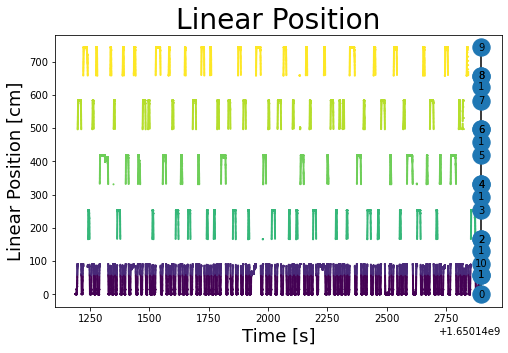

In [55]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(linear_position_df_spy.index,
            linear_position_df_spy.linear_position,
            c=linear_position_df_spy.track_segment_id,
            s=1)
graph.plot_track_graph_as_1D(
    ax=ax,
    axis='y',
    other_axis_start=linear_position_df_spy.index[-1] + 10)

ax.set_xlabel('Time [s]', fontsize=18)
ax.set_ylabel('Linear Position [cm]', fontsize=18)
ax.set_title('Linear Position', fontsize=28)
#plt.xlim(linear_position_df_spy.index[0],linear_position_df_spy.index[-1])